# Take home job application for Eikon Therapeutics.<br>
## Applicant:  Michael Ehrlichman
### email: ehrlichman.m@gmail.com
### phone: 510 295 9039

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.model_selection import train_test_split

df = pd.read_csv("molecules_JD.csv")
df.shape

#Drop the first column, which is a counter
df.drop(columns=df.columns[0],inplace=True);
#The first column is now the name of the molecule


In [2]:
#There are relatively few rows with NaNs.  Simply drop these data from the dataframe.
print(df.shape)
df.isnull().sum(axis=0)
nan_counts = [df[i].isna().sum() for i in df.columns if df[i].isna().any()]
df.dropna(axis=0,inplace=True)
print(df.shape)
#print(df.duplicated().any())  #check for duplicates

(34960, 1024)
(33586, 1024)


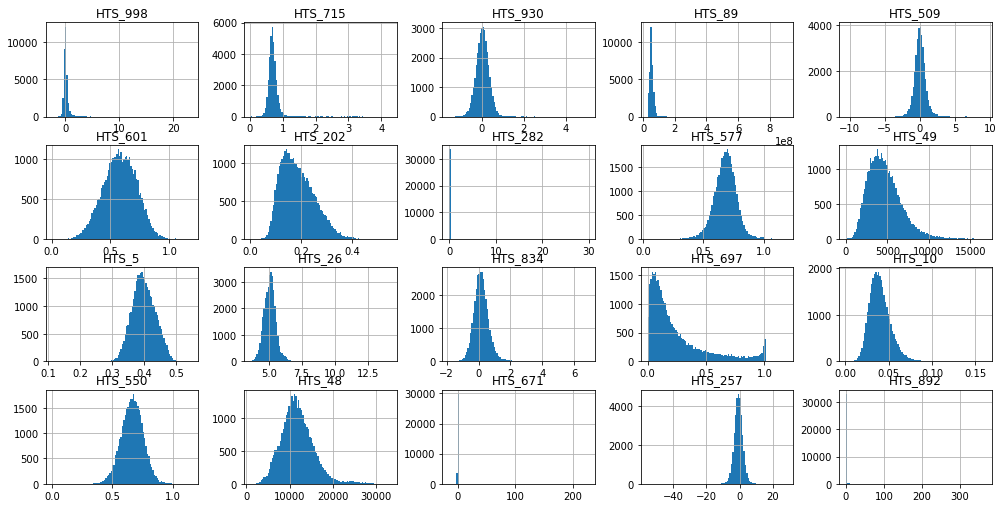

In [3]:
# Plot histograms of a random assortment of columns to get a sense for the data.
random_selection = [random.randint(2,1024) for i in range(20)]
fig, axes = plt.subplots(4,5,sharex=False,sharey=False, figsize=(14,7))
fig.tight_layout()
bp_dict = df[df.columns[random_selection]].hist(ax=axes,bins=100)
# Observations:
# 1) Data is somewhat normally distributed, perhaps better to normalize rather than standardize.
# 2) The x-range suggests the presense of absurd outliers, which will need to be dropped.

In [4]:
# Important hyperparameter here:  max zscore for dropping absurd outliers
zscoremax = 6
df_clean = df[(np.abs(stats.zscore(df[df.columns[2:1025]])) <zscoremax).all(axis=1)]
#df[(np.abs(stats.zscore(df[:]))<3).all(axis=1)]
df_clean.shape

(30232, 1024)

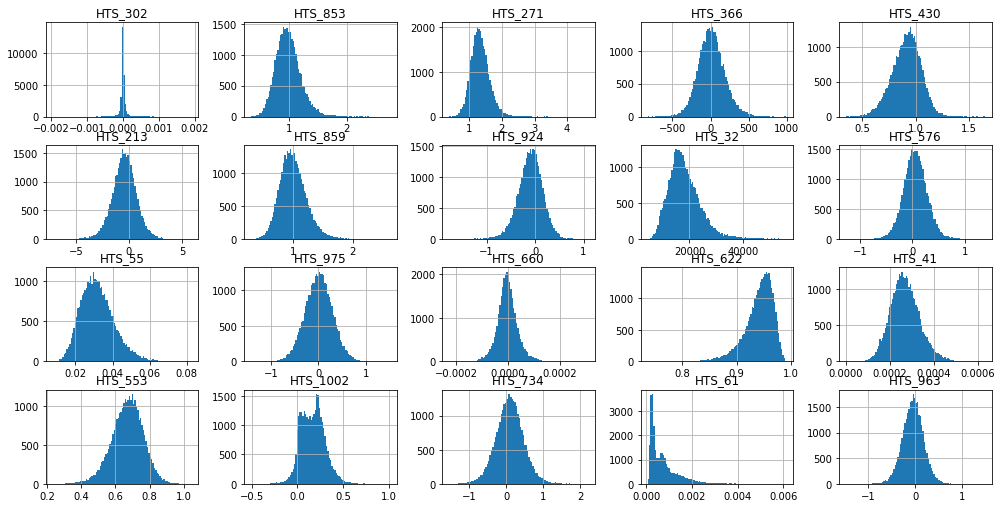

In [5]:
# For df_clean, plot histograms of a random assortment of columns to get a sense for the data.
random_selection = [random.randint(2,df_clean.shape[1]) for i in range(20)]
fig, axes = plt.subplots(4,5,sharex=False,sharey=False, figsize=(14,7))
fig.tight_layout()
df_clean[df_clean.columns[random_selection]].hist(ax=axes,bins=100);

In [155]:
#This is an outlier problem, so we do not need test data.
#We need training data, and validation data to check for over-fitting.
#Also, this is an unsupervised learning problem, so no label.
df_train, df_valid = train_test_split(df_clean, train_size=0.8, random_state=5443)
valid_ix_to_name = df_valid[df_valid.columns[0]]

In [7]:
# The data is clean enough now to normalize
#  Hyperparameter here:  perhaps try standardization, rather than normalization
sel = df_train.columns[1:];
# 'train' the standardization on the training data
selmean = df_train[sel].mean()
selstd = df_train[sel].std()
# standardize both the training and validation data
df_train = (df_train[sel]-selmean)/selstd;
df_valid = (df_valid[sel]-selmean)/selstd;
# add back the molecule labels
df_train.insert(0,df.columns[0],df[df.columns[0]])
df_valid.insert(0,df.columns[0],df[df.columns[0]])

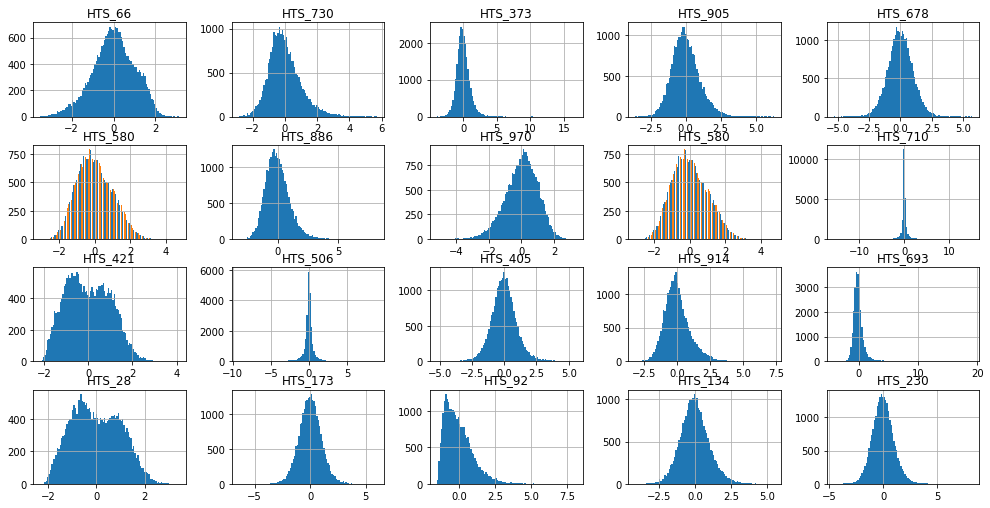

In [8]:
# For df_norm, plot histograms of a random assortment of columns to get a sense for the cleaned, normed data.
random_selection = [random.randint(1,1024) for i in range(20)]
fig, axes = plt.subplots(4,5,sharex=False,sharey=False, figsize=(14,7))
fig.tight_layout()
df_train[df_train.columns[random_selection]].hist(ax=axes,bins=100);

In [9]:
corr_all = df_train.corr();

In [10]:
#Let's see what is going on with the three state features.
#State 1 and state 2 are moderately correlated
#State 0 is correlated with neither state 1 nor state 2
corr_all.iloc[-3:,-3:].style.background_gradient(cmap='coolwarm')

,SYS_0,SYS_1,SYS_2
SYS_0,1.000000,-0.045331,-0.023499
SYS_1,-0.045331,1.000000,0.549425
SYS_2,-0.023499,0.549425,1.000000


correlations with state features
number of very highly correlated pairs: 0.0
number of highly correlated pairs: 1.0
number of moderately correlated pairs: 8.5
number of lowly correlated pairs: 31.5
number of not correlated pairs: 1492.0
total number of pairs: 522753.0
very highly correlated pairs:
highly correlated pairs:
HTS_101  SYS_1    correlation   0.749166
HTS_99   SYS_1    correlation   0.758411
moderately correlated pairs:
HTS_202  SYS_1    correlation  -0.628782
HTS_508  SYS_1    correlation  -0.610207
HTS_406  SYS_1    correlation  -0.609359
HTS_3    SYS_1    correlation  -0.556252
HTS_5    SYS_1    correlation  -0.549726
lowly correlated pairs:
HTS_712  SYS_1    correlation  -0.449131
HTS_27   SYS_0    correlation  -0.448455
HTS_53   SYS_1    correlation  -0.446689
HTS_51   SYS_1    correlation  -0.445761
HTS_42   SYS_1    correlation  -0.437634


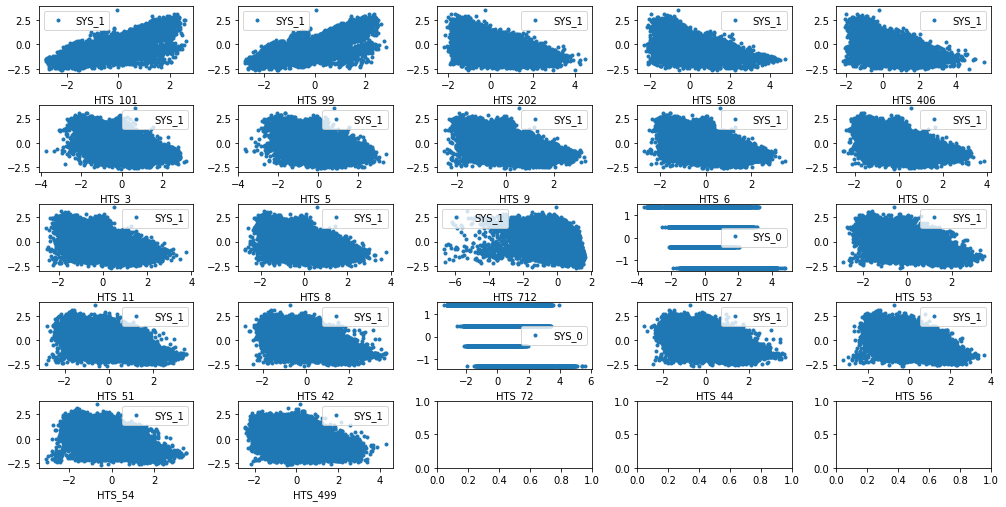

In [12]:
# check HTS feature correlations to state feature SYS_0
vh_pairs = [] #correlations >=0.9
h_pairs = [] #correlations >=0.7 <0.9
m_pairs = [] #correlations >=0.5 <0.7
l_pairs = [] #correlations >=0.3 <0.5
n_pairs = [] #correlations <0.3
for ix,column in enumerate(corr_all.columns):
    for jx,cor in enumerate(corr_all[column][-3:],len(corr_all[column])-3):
        if ix != jx:
            if abs(cor) >= 0.9:
                vh_pairs.append((ix,jx,cor))
            elif abs(cor) >= 0.7:
                h_pairs.append((ix,jx,cor))
            elif abs(cor) >= 0.5:
                m_pairs.append((ix,jx,cor))
            elif abs(cor) >= 0.3:
                l_pairs.append((ix,jx,cor))
            else:
                n_pairs.append((ix,jx,cor))
print("correlations with state features")
print("number of very highly correlated pairs: {}".format(len(vh_pairs)/2))
print("number of highly correlated pairs: {}".format(len(h_pairs)/2))
print("number of moderately correlated pairs: {}".format(len(m_pairs)/2))
print("number of lowly correlated pairs: {}".format(len(l_pairs)/2))
print("number of not correlated pairs: {}".format(len(n_pairs)/2))
print("total number of pairs: {}".format((corr_all.size-corr_all.shape[0])/2))
fig, axes = plt.subplots(5,5, figsize=(14,7))
fig.tight_layout()
axe = [sub for x in axes for sub in x]
ix = 0
print("very highly correlated pairs:")
highest_corr = sorted(vh_pairs,key=lambda x:x[2])
for x,y,c in highest_corr[0:5]:
    print("{:8s} {:8s} correlation {:10f}".format(corr_all.columns[x],corr_all.columns[y],c))
for x,y,_ in highest_corr[0:10]:
    df_train.plot(x=corr_all.columns[x],y=corr_all.columns[y],style='.',ax=axe[ix]);
    ix += 1
print("highly correlated pairs:")
highest_corr = sorted(h_pairs,key=lambda x:x[2])
for x,y,c in highest_corr[0:5]:
    print("{:8s} {:8s} correlation {:10f}".format(corr_all.columns[x],corr_all.columns[y],c))
for x,y,_ in highest_corr[0:10]:
    df_train.plot(x=corr_all.columns[x],y=corr_all.columns[y],style='.',ax=axe[ix]);
    ix += 1
print("moderately correlated pairs:")
highest_corr = sorted(m_pairs,key=lambda x:x[2])
for x,y,c in highest_corr[0:5]:
    print("{:8s} {:8s} correlation {:10f}".format(corr_all.columns[x],corr_all.columns[y],c))
for x,y,_ in highest_corr[0:10]:
    df_train.plot(x=corr_all.columns[x],y=corr_all.columns[y],style='.',ax=axe[ix]);
    ix += 1
print("lowly correlated pairs:")
highest_corr = sorted(l_pairs,key=lambda x:x[2])
for x,y,c in highest_corr[0:5]:
    print("{:8s} {:8s} correlation {:10f}".format(corr_all.columns[x],corr_all.columns[y],c))
for x,y,_ in highest_corr[0:10]:
    df_train.plot(x=corr_all.columns[x],y=corr_all.columns[y],style='.',ax=axe[ix]);
    ix += 1

There are a lot of correlations of data with SYS_1.  This might suggest a problem with the measurements, as he state of the system has a measureable impact on the data.  However, principle component analysis (or similar through an autoencoder) can help deal with the systematic error.

excluding state features
number of very highly correlated pairs: 5457.0
number of highly correlated pairs: 13943.0
number of moderately correlated pairs: 13288.0
number of lowly correlated pairs: 29460.0
number of not correlated pairs: 457542.0
total number of pairs: 522753.0
HTS_3    HTS_21   correlation  -0.991750
HTS_21   HTS_3    correlation  -0.991750
HTS_0    HTS_21   correlation  -0.989660
HTS_21   HTS_0    correlation  -0.989660
HTS_773  HTS_977  correlation  -0.986004


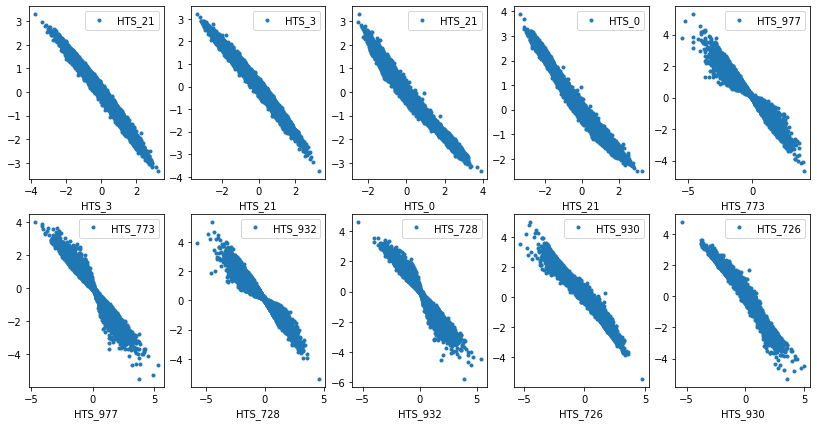

In [14]:
vh_pairs = [] #correlations >=0.9
h_pairs = [] #correlations >=0.7 <0.9
m_pairs = [] #correlations >=0.5 <0.7
l_pairs = [] #correlations >=0.3 <0.5
n_pairs = [] #correlations <0.3
for ix,column in enumerate(corr_all.columns[:-3]):
    for jx,cor in enumerate(corr_all[column][:-3]):
        if ix != jx:
            if abs(cor) >= 0.9:
                vh_pairs.append((ix,jx,cor))
            elif abs(cor) >= 0.7:
                h_pairs.append((ix,jx,cor))
            elif abs(cor) >= 0.5:
                m_pairs.append((ix,jx,cor))
            elif abs(cor) >= 0.3:
                l_pairs.append((ix,jx,cor))
            else:
                n_pairs.append((ix,jx,cor))
print("excluding state features")
print("number of very highly correlated pairs: {}".format(len(vh_pairs)/2))
print("number of highly correlated pairs: {}".format(len(h_pairs)/2))
print("number of moderately correlated pairs: {}".format(len(m_pairs)/2))
print("number of lowly correlated pairs: {}".format(len(l_pairs)/2))
print("number of not correlated pairs: {}".format(len(n_pairs)/2))
print("total number of pairs: {}".format((corr_all.size-corr_all.shape[0])/2))
highest_corr = sorted(vh_pairs,key=lambda x:x[2])
for x,y,c in highest_corr[0:5]:
    print("{:8s} {:8s} correlation {:10f}".format(corr_all.columns[x],corr_all.columns[y],c))
fig, axes = plt.subplots(2,5, figsize=(14,7))
axe = [sub for x in axes for sub in x]
#fig.tight_layout()
for ix,(x,y,_) in enumerate(highest_corr[0:10]):
    df_train.plot(x=corr_all.columns[x],y=corr_all.columns[y],style='.',ax=axe[ix]);

## There are a significant number of very highly and highly correlated pairs in the data.  PCA or outlier detection via an autoencoder should be effective.  But first compute the eigendecomposition of the covariance matrix to get a sense for the degeneracy.

In [17]:
cov_mat = np.cov(df_train[df_train.columns[1:]].T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

(0.8983074846062947+0j)


/home/michael/nc/Private/jupyter/jupyterenv/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/michael/nc/Private/jupyter/jupyterenv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/michael/nc/Private/jupyter/jupyterenv/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


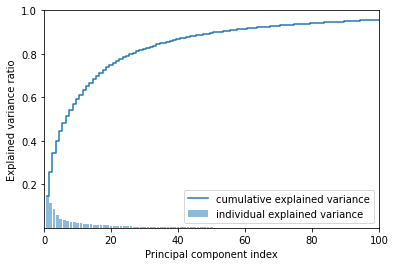

In [18]:
# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp[50])
# plot explained variances
plt.bar(range(1,len(var_exp)+1), var_exp, alpha=0.5,
        align='center', label='individual explained variance',log=False)
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.ylim(10**-3,1)
plt.xlim(0,100)
plt.show()

In [45]:
import tensorflow as tf

tf_train = tf.convert_to_tensor(df_train[df_train.columns[1:]])
tf_valid = tf.convert_to_tensor(df_valid[df_train.columns[1:]])

## Plan for training the model
Setup an autoencoder with a bottleneck of 50, as suggested by the eigen analysis above.
Use mean squared logarithmic error 'msle', because it is less sensitive to outliers, and this fits with our goal of using the autoencoder as an outlier detector.

The hyperparameters below (deep layer size and regularizer) were adjusted such that fit converges to the training data without overtraining (the validation data does not diverge).

There is a lot of hyper tuning that could be done at this stage:<br>
a)  tune encoding_dim<br>
b)  adjust the size and number of the deep layers<br>
c)  activation functions<br>
d)  different optimizer<br>
e)  different loss function<br>
f)  adjust regularizer

In [170]:
import keras
from keras import layers
from keras import regularizers

# This is the size of our bottleneck.
encoding_dim = 50 

input_layer = keras.Input(shape=(df_tf.shape[1],))

encoder = layers.Dense(300, activation='relu')(input_layer)
encoder = layers.Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(encoder)

decoder = layers.Dense(300, activation='relu')(encoder)
decoder = layers.Dense(df_tf.shape[1], activation='tanh')(decoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='msle')

In [171]:
from keras.callbacks import TensorBoard

autoencoder.fit(tf_train, tf_train,
                epochs=400,
                batch_size=32,
                shuffle=True,
                validation_data=(tf_valid, tf_valid),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0636 - val_loss: 0.0529
Epoch 2/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0505 - val_loss: 0.0486
Epoch 3/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0474 - val_loss: 0.0462
Epoch 4/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0454 - val_loss: 0.0449
Epoch 5/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0444 - val_loss: 0.0440
Epoch 6/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0435 - val_loss: 0.0434
Epoch 7/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0429 - val_loss: 0.0427
Epoch 8/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0424 - val_loss: 0.0424
Epoch 9/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0415 - val_loss: 0.0414
Epoch 10/400
756/756 [==============================] - 2s 3ms/step - loss: 0.0409 - val_lo

In [172]:
recon = autoencoder.predict(tf_valid)

mse = np.mean(np.power(tf_valid - recon, 2), axis=1) # / sigma is implicit since features standardized to 1 sigma
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': valid_ix_to_name}, index=df_valid.index)
df_error.describe()

,reconstruction_error
count,6047.000000
mean,0.392088
std,0.392780
min,0.071293
25%,0.208732
50%,0.290884
75%,0.436382
max,13.640216


<AxesSubplot:>

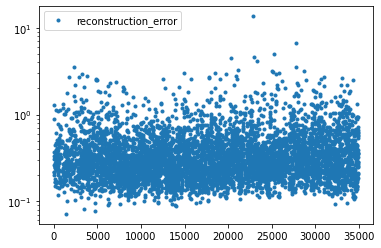

In [173]:
df_error.plot(style='.',logy=True)


For 90% of the data, the reconstruction error (sqrt(sum residual^2)/feature_sigma) is less than 0.64


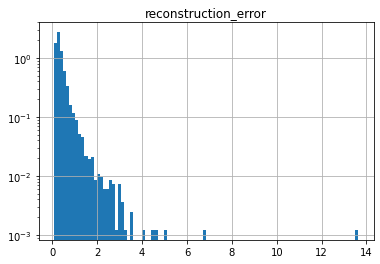

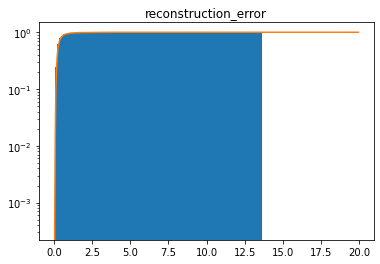

In [243]:
df_error.hist(bins=100,log=True,density=True);
df_error.hist(bins=100,log=True,density=True,cumulative=True);
cum_hist_data = (df_error['reconstruction_error']
 .pipe(lambda s: pd.Series(np.histogram(s, range=(0, 20), bins=500)))
 .pipe(lambda s: pd.Series(s[0], index=s[1][:-1]))
 .pipe(lambda s: np.cumsum(s)/s.sum())
);
cum_hist_data.plot()
for key,val in cum_hist_data.items():
    if val > 0.9:
        result = key
        break
print("For 90% of the data, the reconstruction error (sqrt(sum residual^2)/feature_sigma) is less than 0.64")

## Evaluating the model
As an outlier detector, this model should not fit the data too well.  
We want it to fit the common particles, so as to make the outliers easy to pick out.
As shown in the cumulative histogram above, the model fits the bulk of the data well,
and the outliers can be picked off from the end in order of increasing reconstruction error.
i.e.  The autoencoder can reconstruct the features of most of the molecules well, and the outliers
are those molecules with extraordinary features.<br>
About 90% of the features in the resonctructed dataset have a reconstruction error less than 0.64.  (This indicates that the data is very degenerate, considering that the dataset has 1023 features and the bottleneck is only 50 features.)

The eigenanalysis suggested that 50 principle components would do a good job describing most of the data.  That the model is able to describe the bulk of the data using only 50 engineered features suggests that the model is working as it is intended.

recon_error_threshold set to 1.549 to yield the 100 most significant outliers.  The idea being that these molecules would be suggested for further study.

In [187]:
recon_error = 1.533
outliers = df_error.index[df_error.reconstruction_error > recon_error].tolist()
outliers.sort()
print("number of outliers: {}".format(len(outliers)))
print("top 5 outliers: ", *outliers[:5])

number of outliers: 100
top 5 outliers:  1459 1714 2314 2318 2444


In [188]:
data_n = pd.DataFrame(tf_valid, index=df_valid.index)
def dist_per_feature(point):
    
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,1023)
    reconstrcuted_pt = autoencoder.predict(initial_pt)
    dists = abs(np.array(initial_pt  - reconstrcuted_pt)[0])
    report = []
    for ix,dist in enumerate(dists):
        report.append((df.columns[ix+1],dist))
    report = sorted(report,key=lambda x:-x[1])
    
    return report

Let's examine the strongest outlier, molecule 1459 aka 'M-001459'

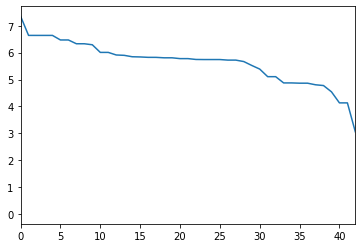

In [189]:
result = dist_per_feature(1459)
plt.plot([x[1] for x in result]);
plt.xlim(0,42);

M-001459 is most outstanding in its first 41 features, after which there is a sharp dropoff.

In [190]:
#Print out the features where M-001459 is most exceptional
print([x[0] for x in result[:41]])

['HTS_383', 'HTS_695', 'HTS_287', 'HTS_689', 'HTS_281', 'HTS_899', 'HTS_893', 'HTS_692', 'HTS_284', 'HTS_896', 'HTS_791', 'HTS_797', 'HTS_792', 'HTS_894', 'HTS_384', 'HTS_389', 'HTS_690', 'HTS_282', 'HTS_897', 'HTS_891', 'HTS_795', 'HTS_789', 'HTS_693', 'HTS_687', 'HTS_285', 'HTS_279', 'HTS_387', 'HTS_381', 'HTS_386', 'HTS_794', 'HTS_182', 'HTS_1001', 'HTS_995', 'HTS_185', 'HTS_179', 'HTS_999', 'HTS_993', 'HTS_180', 'HTS_998', 'HTS_996', 'HTS_177']


Let's examine the next strongest outlier, molecule 1714 aka 'M-001714'

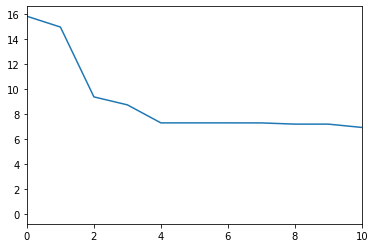

In [192]:
result = dist_per_feature(1714)
plt.plot([x[1] for x in result]);
plt.xlim(0,10);

M-001714 is most outstanding in its first 2 features, after which there is a sharp dropoff.

In [193]:
#Print out the features where M-001714 is most exceptional
print([x[0] for x in result[:2]])

['HTS_289', 'HTS_288']


Let's examine the next strongest outlier, molecule 2314 aka 'M-002314'

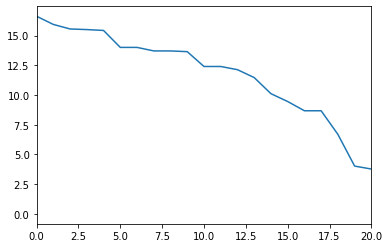

In [194]:
result = dist_per_feature(2314)
plt.plot([x[1] for x in result]);
plt.xlim(0,20);

M-002314 is most outstanding in its first 19 features, after which there is a sharp dropoff.

In [195]:
#Print out the features where M-002314 is most exceptional
print([x[0] for x in result[:19]])

['HTS_181', 'HTS_895', 'HTS_283', 'HTS_691', 'HTS_280', 'HTS_898', 'HTS_892', 'HTS_286', 'HTS_688', 'HTS_694', 'HTS_184', 'HTS_178', 'HTS_900', 'HTS_901', 'HTS_288', 'HTS_289', 'HTS_76', 'HTS_82', 'HTS_79']


# Final Report

There are many correlations in the data with SYS_1.  This might suggest a problem with the measurements, as the state of the system has a measureable impact on the data.  Principle component analysis (or similar through an autoencoder) can help deal with the systematic error.

Eigenanalysis was used to identify that 90% of the variance in the 1023 dimensional feature space could be explained with about 50 variables.  An autoencoder was used to compress the feature space down to 50 variables.
With the trained autoencoder, a few outliers were identified in a validation set containing 20% of the data.  The commentary could be repeated for additional outliers.

As mentioned above in the comentary, the model is doing what it was intended to do.  The eigenanalysis suggested that 90% of the variance in the data could be described with 50 principal components.  The model has a bottleneck of 50 engineered features, and the reconstruction error for 90% of the data is better than 0.64.  This outlier model effectively allows us to pick off the molecules that most strongly deviate from the norm.

## Next Steps
a)  Tune the autoencoder model as described in that cell.<br>
b)  Repeat the analysis 4 more times, using a different 20% of the data each time for validation, so that outliers across the entire data set can be identified.<br>
c)  Try standardization, rather than normalization, since the data is fairly gaussian.<br>
d)  Develop several autoencoder models with different layers and regularization, then combine the results using an averaging technique.<br>